# SkyCam Centroid Fit

Study the implementation of fast centroid fitting for SkyCam data, used by the ETC [here](https://github.com/desihub/desietc/blob/main/desietc/sky.py). See [DESI-8945](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=8945) for details.

This notebook and the data it uses are maintained in the [fpoffline github repo](https://github.com/desihub/fpoffline/tree/main/nb/SkyCamUpdate). Expand the `fast.tgz` and `slow.tgz` archives to reproduce the plots below.

This notebook is written to run locally, instead of at NERSC, but uses several files you will need to download first:
 - `exposures-daily.csv` : https://data.desi.lbl.gov/desi/spectro/redux/daily/exposures-daily.csv
 - `SKY_calib.fits` : https://data.desi.lbl.gov/desi/cmx/sky/calib/SKY_calib.fits
 - `sky-00226756.fits.fz` : https://data.desi.lbl.gov/desi/spectro/data/20240222/00226756/sky-00226756.fits.fz 

In [2]:
%matplotlib inline

In [3]:
import time

In [4]:
import json
import pathlib

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import pandas as pd

In [7]:
import fitsio

In [8]:
import desietc.sky
import desietc.util
import desietc.plot

## Plots of Single Exposures

In [9]:
SKY = desietc.sky.SkyCamera(calib_name='SKY_calib.fits')

In [10]:
path = 'sky-00226756.fits.fz'

In [11]:
raw = [ fitsio.read(path, ext='SKYCAM0'), fitsio.read(path, ext='SKYCAM1') ]

FAST dx 0.38 dy 1.70 flux [120100.1  90295.8 123567.4 125076.6 166411.1  89646.4  83174.6 131931.6] bg [0.98 1.56 0.99 1.56 0.96 1.49 1.57 1.74]
fluxerr [341.93  298.756 326.525 314.689 322.304 252.645 345.734 331.527] elapsed 225.9ms


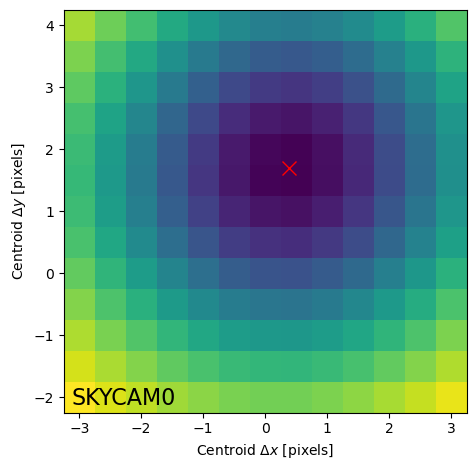

In [12]:
desietc.plot.plotSkyCentroidFit(raw[0][0], 'SKYCAM0', SKY, plot_fine=False, slow=False)
plt.tight_layout()
plt.savefig('sky0-00226756-a.png')

FAST dx -0.80 dy 0.62 flux [109439.7 132249.5 123899.1 139483.8  36062.3 131332.9] bg [1.34 1.13 1.18 1.11 1.76 1.93]
fluxerr [271.982 305.699 289.633 290.252 210.45  307.126] elapsed 190.1ms


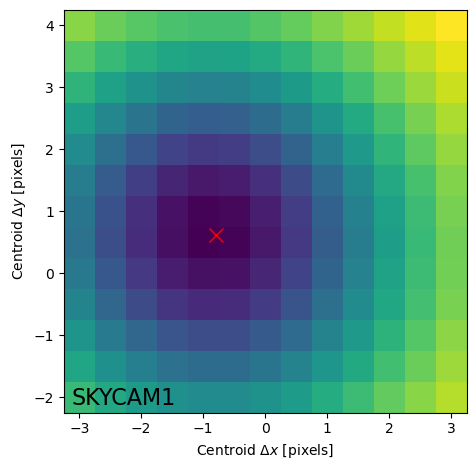

In [13]:
desietc.plot.plotSkyCentroidFit(raw[1][0], 'SKYCAM1', SKY, plot_fine=False, slow=False)
plt.tight_layout()
plt.savefig('sky1-00226756-a.png')

FAST dx 0.38 dy 1.70 flux [120100.1  90295.8 123567.4 125076.6 166411.1  89646.4  83174.6 131931.6] bg [0.98 1.56 0.99 1.56 0.96 1.49 1.57 1.74]
fluxerr [341.93  298.756 326.525 314.689 322.304 252.645 345.734 331.527] elapsed 216.0ms


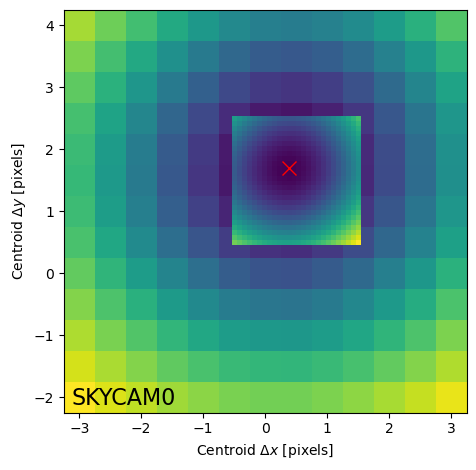

In [14]:
desietc.plot.plotSkyCentroidFit(raw[0][0], 'SKYCAM0', SKY, plot_fine=True, slow=False)
plt.tight_layout()
plt.savefig('sky0-00226756-b.png')

FAST dx -0.80 dy 0.62 flux [109439.7 132249.5 123899.1 139483.8  36062.3 131332.9] bg [1.34 1.13 1.18 1.11 1.76 1.93]
fluxerr [271.982 305.699 289.633 290.252 210.45  307.126] elapsed 170.3ms


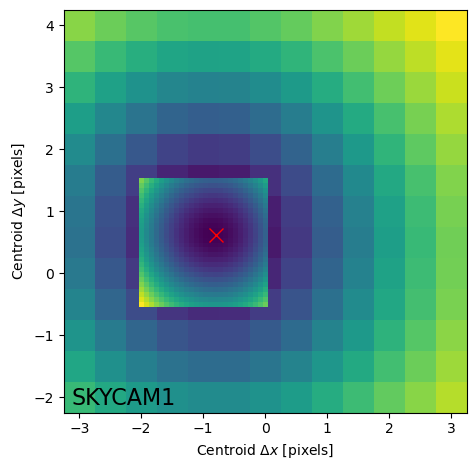

In [15]:
desietc.plot.plotSkyCentroidFit(raw[1][0], 'SKYCAM1', SKY, plot_fine=True, slow=False)
plt.tight_layout()
plt.savefig('sky1-00226756-b.png')

FAST dx 0.38 dy 1.70 flux [120100.1  90295.8 123567.4 125076.6 166411.1  89646.4  83174.6 131931.6] bg [0.98 1.56 0.99 1.56 0.96 1.49 1.57 1.74]
fluxerr [341.93  298.756 326.525 314.689 322.304 252.645 345.734 331.527] elapsed 232.6ms
SLOW dx 0.39 dy 1.80 flux [119781.9  90040.4 123506.4 125458.9 165820.8  89462.6  83626.8 132007. ] bg [0.99 1.57 0.99 1.56 0.97 1.5  1.55 1.74]
fluxerr [344.043 298.977 326.7   315.829 322.738 252.737 350.514 334.573] elapsed 6192.9ms


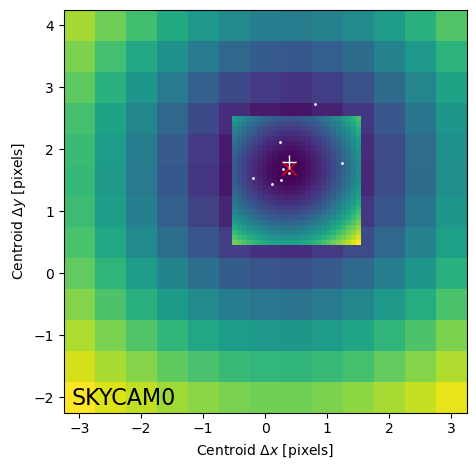

In [16]:
desietc.plot.plotSkyCentroidFit(raw[0][0], 'SKYCAM0', SKY, plot_fine=True, slow=True)
plt.tight_layout()
plt.savefig('sky0-00226756-c.png')

FAST dx -0.80 dy 0.62 flux [109439.7 132249.5 123899.1 139483.8  36062.3 131332.9] bg [1.34 1.13 1.18 1.11 1.76 1.93]
fluxerr [271.982 305.699 289.633 290.252 210.45  307.126] elapsed 151.7ms
SLOW dx -0.83 dy 0.70 flux [109634.3 132463.2 124117.  139918.1  36207.5 131176. ] bg [1.33 1.12 1.17 1.1  1.75 1.92]
fluxerr [273.096 306.882 291.666 292.219 212.505 309.506] elapsed 2464.8ms


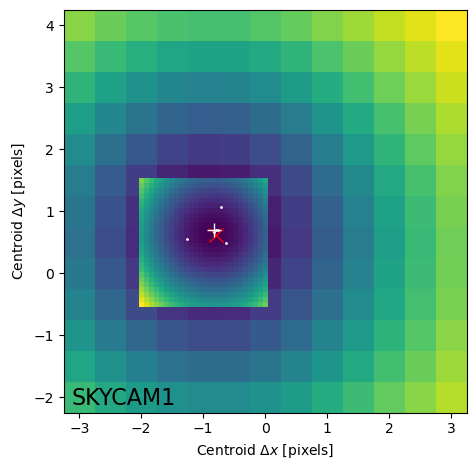

In [17]:
desietc.plot.plotSkyCentroidFit(raw[1][0], 'SKYCAM1', SKY, plot_fine=True, slow=True)
plt.tight_layout()
plt.savefig('sky1-00226756-c.png')

## Plots Comparing Slow and Fast over Multiple Nights

In [18]:
def load_exposures():

    data = fitsio.read('exposures-daily.fits', ext='EXPOSURES')
    df = pd.DataFrame(data.byteswap().newbyteorder())
    df = df[['NIGHT','EXPID','MJD','SURVEY','PROGRAM','SKY_MAG_G_SPEC','SKY_MAG_R_SPEC','SKY_MAG_Z_SPEC']]
    for band in 'GRZ':
        mag = df['SKY_MAG_%s_SPEC' % band]
        # https://www.sdss3.org/dr8/algorithms/magnitudes.php#nmgy
        nmg = 10 ** ((22.5 - mag) / 2.5)
        df['FLUX_%s' % band] = nmg
        # https://desi.lbl.gov/trac/wiki/SurveyOps/SurveySpeed#NominalSkyValues
        df['SKY_%s' % band] = nmg / 3.73
    return df

exposures = load_exposures()

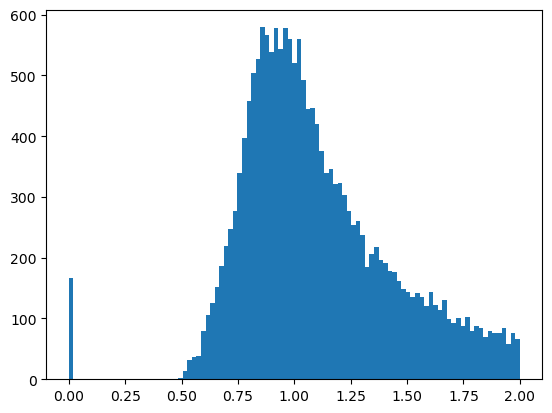

In [19]:
plt.hist(exposures.SKY_R, bins=np.linspace(0, 2, 100));

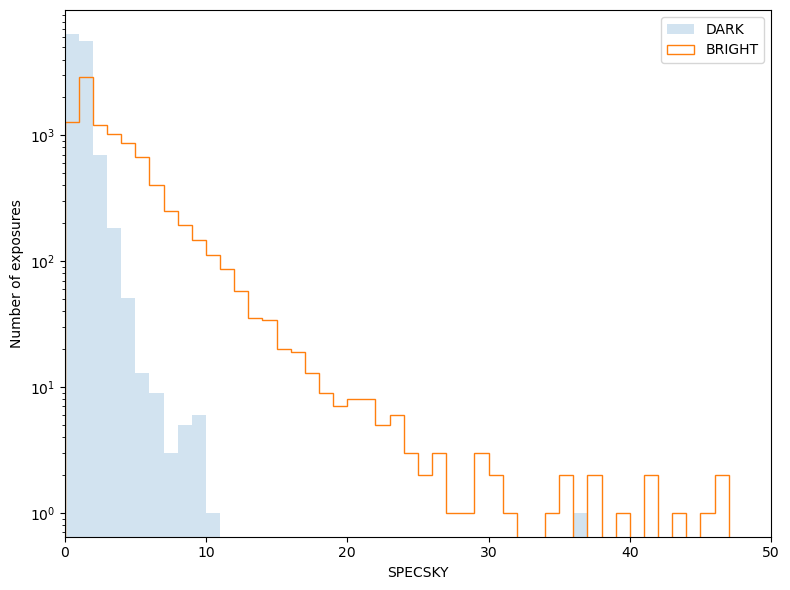

In [20]:
def plot_specsky():
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    bins = np.linspace(0, 50, 51)
    ax.hist(exposures.SKY_R[exposures.PROGRAM=='dark'], bins=bins, histtype='stepfilled', alpha=0.2, label='DARK')
    ax.hist(exposures.SKY_R[exposures.PROGRAM=='bright'], bins=bins, histtype='step', label='BRIGHT')
    ax.set(xlim=(bins[0], bins[-1]), xlabel='SPECSKY', ylabel='Number of exposures', yscale='log')
    ax.legend()
    plt.tight_layout()
    plt.savefig('specsky.png')

plot_specsky()

In [24]:
def merge_nights(verbose=False):

    slow_nights = set([ p.name[7:15] for p in pathlib.Path('slow').glob('etcsky-*.json') ])
    fast_nights = set([ p.name[7:15] for p in pathlib.Path('fast').glob('etcsky-*.json') ])
    nights = sorted(slow_nights & fast_nights)
    print(f'Found {len(slow_nights)} slow nights, {len(fast_nights)} fast nights, {len(nights)} common nights')

    frame_rows = [ ]
    exp_rows = [ ]
    for night in nights:
        slow_data = json.load(open(f'slow/etcsky-{night}.json'))
        fast_data = json.load(open(f'fast/etcsky-{night}.json'))
        slow_expids = set([ int(exp['exptag']) for exp in slow_data['exps'] ])
        fast_expids = set([ int(exp['exptag']) for exp in fast_data['exps'] ])
        if slow_expids != fast_expids:
            if verbose:
                print(f'Fast / slow exposure IDs do not match for {night}')
                print(f'  only slow: {slow_expids - fast_expids}')
                print(f'  only fast: {fast_expids - slow_expids}')
            all_expids = sorted(slow_expids & fast_expids)
        else:
            all_expids = sorted(slow_expids)
        fast_expids = sorted(fast_expids)
        slow_expids = sorted(slow_expids)
        for expid in all_expids:
            ifast = fast_expids.index(expid)
            islow = slow_expids.index(expid)
            nframes_fast = np.array(fast_data['exps'][ifast]['combined']).shape[1]
            nframes_slow = np.array(slow_data['exps'][islow]['combined']).shape[1]
            if nframes_fast != nframes_slow:
                if verbose:
                    print(f'Fast / slow frame counts do not match for {night}/{expid}: {nframes_fast} != {nframes_slow}')
                continue

            # Match with the exposures table to get the program and spec sky value
            sel = exposures.EXPID==expid
            if not np.any(sel):
                if verbose:
                    print(f'No exposure data found for {night}/{expid}')
                continue
            prog = exposures.PROGRAM[sel].values[0]
            specsky = exposures.SKY_R[sel].values[0]
            if specsky < 0.25 or specsky > 100.0:
                if verbose:
                    print(f'{night}/{expid} has invalid specsky {specsky}')
                continue

            slow_flux = np.array(slow_data['exps'][islow]['flux'])
            fast_flux = np.array(fast_data['exps'][ifast]['flux'])
            # sum over cameras
            slow_elapsed = np.array(slow_data['exps'][islow]['elapsed']).sum(axis=1)
            fast_elapsed = np.array(fast_data['exps'][ifast]['elapsed']).sum(axis=1)
            for frame in range(nframes_fast):
                row = {
                    'NIGHT': night, 'EXPID': expid, 'PROG': prog, 'FRAME': frame,
                    # without temperature corrections
                    'FAST0': fast_flux[2,0,frame], 'SLOW0': slow_flux[2,0,frame],
                    'FAST1': fast_flux[2,1,frame], 'SLOW1': slow_flux[2,1,frame],
                    'ORIG0': fast_flux[0,0,frame], 'ORIG1': fast_flux[0,1,frame],
                    # timing
                    'TFAST': fast_elapsed[1, frame], 'TSLOW': slow_elapsed[1, frame],
                    'TORIG': fast_elapsed[0, frame],
                }
                frame_rows.append(row)

            slow_mean = np.array(slow_data['exps'][islow]['mean'])
            fast_mean = np.array(fast_data['exps'][ifast]['mean'])
            row = {
                'NIGHT': night, 'EXPID': expid, 'PROG': prog, 'SPECSKY': specsky,
                # without temperature corrections
                'FAST': fast_mean[2], 'SLOW': slow_mean[2], 'ORIG': fast_mean[0],
                'FAST0': fast_flux[2,0].mean(), 'SLOW0': slow_flux[2,0].mean(),
                'FAST1': fast_flux[2,1].mean(), 'SLOW1': slow_flux[2,1].mean(),
                'ORIG0': fast_flux[0,0].mean(), 'ORIG1': fast_flux[0,1].mean(),
                # including temperature corrections
                'FAST_TMP': fast_mean[1], 'SLOW_TMP': slow_mean[1],
                'FAST0_TMP': fast_flux[1,0].mean(), 'SLOW0_TMP': slow_flux[1,0].mean(),
                'FAST1_TMP': fast_flux[1,1].mean(), 'SLOW1_TMP': slow_flux[1,1].mean(),
            }
            exp_rows.append(row)

    df_frames = pd.DataFrame(frame_rows)
    df_exps = pd.DataFrame(exp_rows)
    all_nights = df_exps.NIGHT.unique()
    num_nights = len(all_nights)
    print(f'Merged {len(frame_rows)} frames from {len(exp_rows)} exposures and {num_nights} nights {all_nights[0]}-{all_nights[-1]}')
    return df_frames, df_exps

df_frames, df_exps = merge_nights(verbose=False)

Found 972 slow nights, 977 fast nights, 972 common nights
Merged 303229 frames from 26618 exposures and 970 nights 20200227-20250208


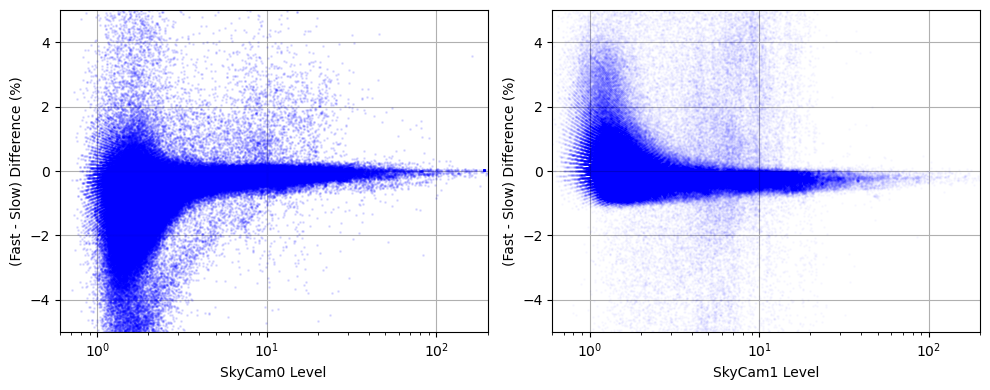

In [15]:
def plot_merged_frames():

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # SKYCAM0
    ax = axes[0]
    avg = (df_frames.SLOW0 + df_frames.FAST0) / 2
    pctdif = (df_frames.FAST0 - df_frames.SLOW0) / avg * 100
    ax.plot(avg, pctdif, 'b.', ms=2, alpha=0.1)
    ax.set(xlim=(0.6, 200), ylim=(-5, 5), xscale='log', xlabel='SkyCam0 Level', ylabel='(Fast - Slow) Difference (%)')
    ax.grid()

    # SKYCAM1
    ax = axes[1]
    avg = (df_frames.SLOW1 + df_frames.FAST1) / 2
    pctdif = (df_frames.FAST1 - df_frames.SLOW1) / avg * 100
    ax.plot(avg, pctdif, 'b.', ms=2, alpha=0.02)
    ax.set(xlim=(0.6, 200), ylim=(-5, 5), xscale='log', xlabel='SkyCam1 Level', ylabel='(Fast - Slow) Difference (%)')
    ax.grid()

    plt.tight_layout()
    plt.savefig('merged_frames.png')

plot_merged_frames()

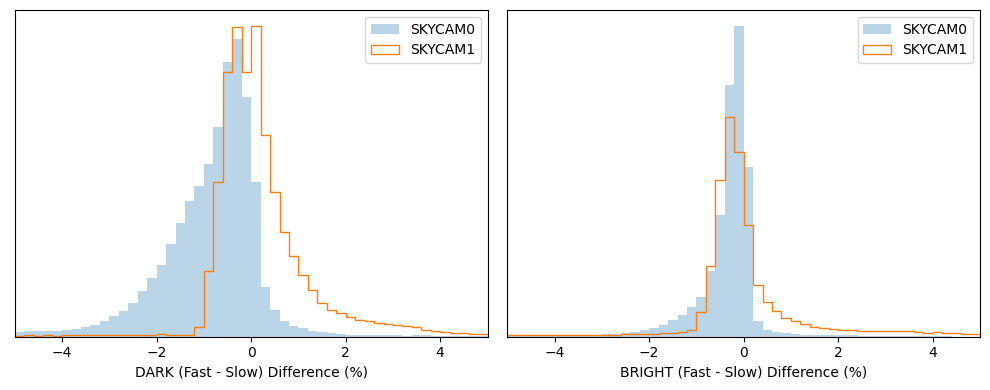

In [13]:
def plot_merged_hist():

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    bins = np.linspace(-5,5,51)

    avg0 = (df_frames.SLOW0 + df_frames.FAST0) / 2
    ratio0 = 100 * (df_frames.FAST0 - df_frames.SLOW0) / avg0
    avg1 = (df_frames.SLOW1 + df_frames.FAST1) / 2
    ratio1 = 100 * (df_frames.FAST1 - df_frames.SLOW1) / avg1

    # DARK
    ax = axes[0]
    DARK = df_frames.PROG == "dark"
    ax.hist(ratio0[DARK], bins=bins, histtype='stepfilled', label='SKYCAM0', alpha=0.3)
    ax.hist(ratio1[DARK], bins=bins, histtype='step', label='SKYCAM1')
    ax.legend()
    ax.set(xlabel='DARK (Fast - Slow) Difference (%)', yticks=[], xlim=(bins[0], bins[-1]))

    # BRIGHT
    ax = axes[1]
    BRIGHT = df_frames.PROG == "bright"
    ax.hist(ratio0[BRIGHT], bins=bins, histtype='stepfilled', label='SKYCAM0', alpha=0.3)
    ax.hist(ratio1[BRIGHT], bins=bins, histtype='step', label='SKYCAM1')
    ax.legend()
    ax.set(xlabel='BRIGHT (Fast - Slow) Difference (%)', yticks=[], xlim=(bins[0], bins[-1]))

    plt.tight_layout()
    plt.savefig('merged_hist.png')

plot_merged_hist()

SLOW / FAST 35.233911000345


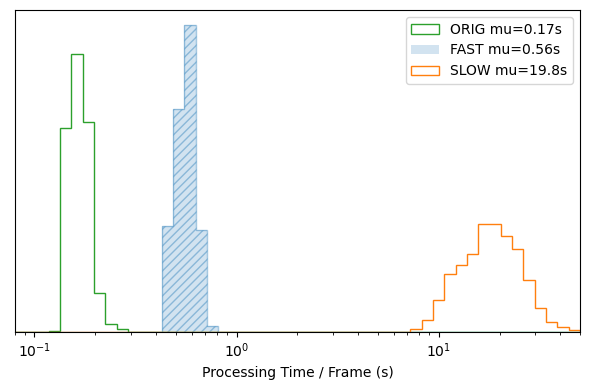

In [14]:
def plot_merged_elapsed(orig=True):

    fig, axes = plt.subplots(1, 1, figsize=(6, 4))

    # FAST, ORIG
    ax = axes
    bins = np.geomspace(0.08, 50, 51)
    fmu,smu,omu = np.mean(df_frames.TFAST), np.mean(df_frames.TSLOW), np.mean(df_frames.TORIG)
    if orig:
        ax.hist(df_frames.TORIG, bins=bins, histtype='step', color='C2', alpha=1, label=f'ORIG mu={omu:.2f}s')
    ax.hist(df_frames.TFAST, bins=bins, histtype='stepfilled', fc='C0', alpha=0.2, label=f'FAST mu={fmu:.2f}s')
    ax.hist(df_frames.TFAST, bins=bins, histtype='step', hatch='////', ec='C0', alpha=0.4)
    ax.hist(df_frames.TSLOW, bins=bins, histtype='step', color='C1', alpha=1, label=f'SLOW mu={smu:.1f}s')
    ax.set(xscale='log', xlabel='Processing Time / Frame (s)', yticks=[], xlim=(bins[0], bins[-1]))
    ax.legend()

    print('SLOW / FAST', smu / fmu)

    plt.tight_layout()
    plt.savefig('merged_elapsed.png')

plot_merged_elapsed()

In [27]:
def plot_merged_exps(orig=True, which='', temp=True, save='merged_exps.png'):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    bins = np.linspace(1, 2, 26)
    clipped_mu = lambda x: np.mean(np.clip(x, 0.8, 2.2))
    clipped_std = lambda x: np.std(np.clip(x, 0.8, 2.2))

    T = '_TMP' if temp else ''
    fname = f'FAST{which}{T}'
    sname = f'SLOW{which}{T}'
    oname = f'ORIG{which}'
    fast_ratio = df_exps[fname] / df_exps.SPECSKY
    slow_ratio = df_exps[sname] / df_exps.SPECSKY
    orig_ratio = df_exps[oname] / df_exps.SPECSKY

    # DARK
    ax = axes[0]
    DARK = df_exps.PROG == "dark"
    fmu, smu, omu = clipped_mu(fast_ratio[DARK]), clipped_mu(slow_ratio[DARK]), clipped_mu(orig_ratio[DARK])
    fstd, sstd, ostd = clipped_std(fast_ratio[DARK]), clipped_std(slow_ratio[DARK]), clipped_std(orig_ratio[DARK])
    ax.hist(fast_ratio[DARK], bins=bins, histtype='stepfilled', fc='C0', alpha=0.2, label=f'FAST $\mu={fmu:.3f}\ \sigma/\mu={fstd/fmu:.3f}$')
    ax.hist(fast_ratio[DARK], bins=bins, histtype='step', hatch='////', ec='C0', alpha=0.4)
    ax.hist(slow_ratio[DARK], bins=bins, histtype='step', color='C1', alpha=1, label=f'SLOW $\mu={smu:.3f}\ \sigma/\mu={sstd/smu:.3f}$')
    if orig:
        ax.hist(orig_ratio[DARK], bins=bins, histtype='step', color='C2', alpha=1, label=f'ORIG $\mu={omu:.3f}\ \sigma/\mu={ostd/omu:.3f}$')
    ax.legend(loc='upper left', fontsize='small')
    ax.set(xlabel=f'DARK ETCSKY{which} / SPECSKY', ylabel='Exposures', xlim=(1,2))

    # BRIGHT
    ax = axes[1]
    BRIGHT = (df_exps.PROG == "bright") #| (df_exps.PROG == "backup")
    fmu, smu, omu = clipped_mu(fast_ratio[BRIGHT]), clipped_mu(slow_ratio[BRIGHT]), clipped_mu(orig_ratio[BRIGHT])
    fstd, sstd, ostd = clipped_std(fast_ratio[BRIGHT]), clipped_std(slow_ratio[BRIGHT]), clipped_std(orig_ratio[BRIGHT])
    ax.hist(fast_ratio[BRIGHT], bins=bins, histtype='stepfilled', fc='C0', alpha=0.2, label=f'FAST $\mu={fmu:.3f}\ \sigma/\mu={fstd/fmu:.3f}$')
    ax.hist(fast_ratio[BRIGHT], bins=bins, histtype='step', hatch='////', ec='C0', alpha=0.4)
    ax.hist(slow_ratio[BRIGHT], bins=bins, histtype='step', color='C1', alpha=1, label=f'SLOW $\mu={smu:.3f}\ \sigma/\mu={sstd/smu:.3f}$')
    if orig:
        ax.hist(orig_ratio[BRIGHT], bins=bins, histtype='step', color='C2', alpha=1, label=f'ORIG $\mu={omu:.3f}\ \sigma/\mu={ostd/omu:.3f}$')
    ax.legend(loc='upper left', fontsize='small')
    ax.set(xlabel=f'BRIGHT ETCSKY{which} / SPECSKY', ylabel='Exposures', xlim=(1,2))

    plt.tight_layout()
    if save:
        plt.savefig(save)

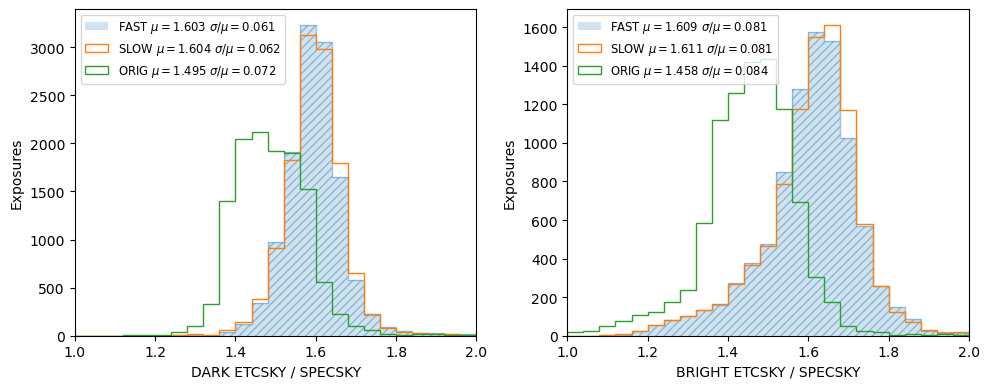

In [28]:
plot_merged_exps(orig=True, temp=True, save='merged_exps.png')

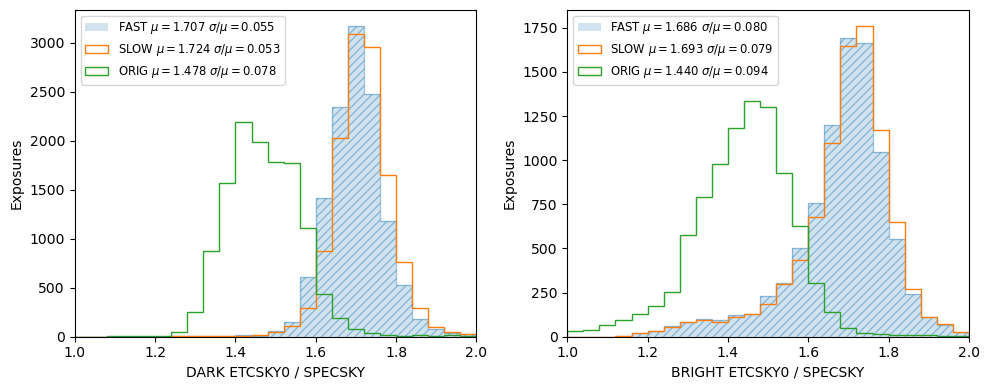

In [29]:
plot_merged_exps(which='0', orig=True, temp=True, save='merged_exps_skycam0.png')

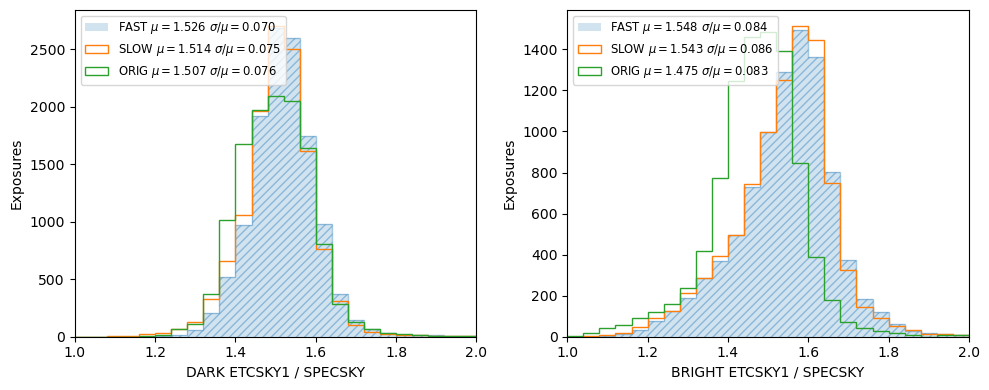

In [30]:
plot_merged_exps(which='1', orig=True, temp=True, save='merged_exps_skycam1.png')